# Mocap Data Development

The goal of this stage was to understand the data, create a data processing pipeline in *Julia*, and

* be able to create training / test data from raw files.
* be able to reconstruct such data (and modelled data) into animations.

**THIS IS NOW COMPLETE AND THE WORK MOVED INTO ./io.jl**

In [2]:
using LinearAlgebra, Statistics, Random
using Quaternions    # For manipulating 3D Geometry
using MeshCat        # For web visualisation / animation
using PyPlot         # Plotting
using AxUtil, Flux   # Optimisation

# small utils libraries
using ProgressMeter, Formatting, ArgCheck
using NPZ

# global utils
squeeze(x) = dropdims(x, dims=tuple(findall(size(x) .== 1)...))  # may be an official fn, but not sure where
unsqueeze(xs, dim) = reshape(xs, (size(xs)[1:dim-1]..., 1, size(xs)[dim:end]...))  # <= from Flux.jl
rowmaj_reshape_3d(x, ix, iy, iz) = (x=reshape(x, ix, iz, iy); permutedims(x, [1,3,2]);)

DIR_MOCAP_MTDS = "../../../mocap-mtds/";   # different cos I'm in dev folder

# MeshCat skeleton visualisation tools
include(joinpath(DIR_MOCAP_MTDS, "mocap_viz.jl"))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13883453685414230871\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-15380243074905115122\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/5794a0bf2e6325e42dc09c7369026176a04edd3e-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-13883453685414230871\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

Main.mocapviz

In [987]:
include(joinpath(DIR_MOCAP_MTDS, "io.jl"))

Main.mocapio

In [3]:
# Python interface to reuse Dan Holden's code
using PyCall

# add to PATH
map(["", joinpath(DIR_MOCAP_MTDS, "pyfiles")]) do p
    pushfirst!(PyVector(pyimport("sys")."path"), p); end

# imports
BVHpy = pyimport("BVH");
Animpy = pyimport("Animation");
Quatpy = pyimport("Quaternions");
Pivotspy = pyimport("Pivots")
filterspy = pyimport("scipy.ndimage.filters")   # note scipy not dl by default by Julia

PyObject <module 'scipy.ndimage.filters' from '/Users/alexbird/.julia/conda/3/lib/python3.7/site-packages/scipy/ndimage/filters.py'>

In [4]:
# PyCall Utility Functions
toArray(x) = convert(Array, x)   # Quatpy class operations return Python objects (numpy). Forces convert.
collapseDim3Jl(x) = reshape(x, size(x, 1), :)
collapseDim3Npy(x) = (x=permutedims(x, [1,3,2]); reshape(x, size(x, 1), :);)

# class method __getitem__ def in Quaternions.py doesn't play nicely. Let's write our own:
QuatpyGetItem(pyo, ixs...) = Quatpy.Quaternions(pyo.qs[(ixs..., :, :, :)[1:ndims(pyo.qs)]...])

QuatpyGetItem (generic function with 1 method)

-------------------
## Extract relevant details from BVH file

* Rotational velocity about root [1],
* Global velocity of root in $x, z$ directions [2,3],
* Foot contact points (L,R,heel,toe) [4,5,6,7],
* Local joint positions (rel. to root) x21 x3 [8-70],
* Local joint velocities (rel. to root) x21 x3 [71-133],
* Local joint rotations (rel. to root?) x21 x3 [134-196],
* Forward direction (note $\perp$ to $y$, ie. $y=0$) [197-199]

In [955]:
proc2 = mocapio.process_file(files[40])

957×196 Array{Float64,2}:
 -7.44135e-5    0.0185008    0.332072   …   0.0762912   0.360389  0.599597
 -0.00011454   -0.00940999   0.301361       0.0796756   0.360885  0.617338
 -0.000156184   0.0209589    0.355107       0.0813809   0.35567   0.624407
 -0.000199097   0.00478976   0.346394       0.0838546   0.353683  0.635314
 -0.00024298    0.0140304    0.380392       0.0880801   0.346709  0.638559
 -0.000287574   0.0222932    0.355337   …   0.0951806   0.337181  0.641368
 -0.000332587  -0.0282651    0.365414       0.105271    0.330077  0.64363 
 -0.000377726  -0.0294267    0.363344       0.105619    0.329512  0.649729
 -0.000422563  -0.0271975    0.380092       0.10142     0.333237  0.657959
 -0.000466854  -0.0240651    0.382749       0.103784    0.330944  0.663108
 -0.000510194   4.70049e-5   0.381733   …   0.109509    0.323418  0.665098
 -0.000552311  -0.0113437    0.402259       0.112208    0.316032  0.665384
 -0.000592827  -0.0315291    0.384127       0.114711    0.300241  0.660686

In [906]:
function process_file(filename)
    
    anim, names, frametime = BVHpy.load(filename)
    
    # Subsample to 60 fps
    anim = get(anim,  range(0, length(anim)-1, step=2))
    
    # Do FK
    global_xforms = Animpy.transforms_global(anim)  # intermediate
    global_positions = global_xforms[:,:,1:3,4] ./ global_xforms[:,:,4:end,4]
    global_rotations = Quatpy.Quaternions.from_transforms(global_xforms)
    

    # Remove Uneeded Joints
    used_joints = [0, 2,  3,  4,  5, 7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 22, 25, 26, 27, 29] .+ 1
         
    positions = global_positions[:, used_joints,:]
    global_rotations = QuatpyGetItem(global_rotations,:,used_joints,:) 
    N = size(positions, 1)
    # ________________________________________________________

    # Put on Floor
    positions[:,:,2] .-= minimum(positions[:,:,2])
    
    # Get Foot Contacts
    # ------------------------------------------
    # >>>> SMOOTH FIRST? <<<<<<<<<<<<<<<
    # ------------------------------------------
    velfactor, heightfactor = [0.05,0.05], [3.0, 2.0]
    fid_l, fid_r = [3,4] .+1, [7,8] .+1
    
    feet_l_vmag_sq = sum(x->x^2, diff(positions[:, fid_l, 1:3], dims=1), dims=3) |> squeeze
    feet_l_h = positions[1:end-1, fid_l, 2]
    feet_l = (feet_l_vmag_sq .< velfactor') .& (feet_l_h .< heightfactor')
    
    feet_r_vmag_sq = sum(x->x^2, diff(positions[:, fid_r, 1:3], dims=1), dims=3) |> squeeze
    feet_r_h = positions[1:end-1, fid_r, 2]
    feet_r = (feet_r_vmag_sq .< velfactor') .& (feet_r_h .< heightfactor')
    
    # Get Root Velocity
    velocity = diff(positions[:,1:1,:], dims=1)
    
    # Remove translation
    positions[:,:,1] .-= positions[:,1:1,1]
    positions[:,:,3] .-= positions[:,1:1,3]
    
    # Get Forward Direction
    sdr_l, sdr_r, hip_l, hip_r = 14, 18, 2, 6  #13, 17, 1, 5
    across1 = positions[:,hip_l,:] - positions[:,hip_r,:]
    across0 = positions[:,sdr_l,:] - positions[:,sdr_r,:]
    across = across0 + across1
    across = across ./ sqrt.(sum(x->x^2, across, dims=2))
    
    direction_filterwidth = 20
#     forward = [cross(view(across, i,:), [0., 1, 0])' for i in 1:N] |>  x->reduce(vcat, x)  # crossprod
    forward = hcat(-across[:,3], zeros(size(across, 1), 1), across[:,1])  # crossprod (easy as spec. case)
    forward = filterspy.gaussian_filter1d(forward, direction_filterwidth, axis=0, mode="nearest")
    forward = forward ./ sqrt.(sum(x->x^2, forward, dims=2))
    
    # Get Root Rotation
    target = repeat([0,0,1]', N, 1)
    root_rotation = Quatpy.Quaternions.between(forward, target)
    root_rotation.qs = unsqueeze(root_rotation.qs, 2);
    root_rot_omitlast = QuatpyGetItem(root_rotation, 1:(N-1)) 
    rvelocity = (QuatpyGetItem(root_rotation, 2:N) * -root_rot_omitlast).to_pivots()
    
    # Local Space  # NEW: define position of joints relative to root
    local_positions = positions  # copy(positions)
    local_positions[:,:,1] .-= local_positions[:,1:1,1]  # x rel to root x
    local_positions[:,:,3] .-= local_positions[:,1:1,3]  # z rel to root z
    
    local_positions = root_rot_omitlast * local_positions[1:end-1,:,:]  |> toArray # remove Y rotation from pos
    local_velocities = diff(local_positions, dims=1)
    local_rotations = abs((root_rot_omitlast * QuatpyGetItem(global_rotations, 1:(N-1)))).log()
    
    root_rvelocity = Pivotspy.Pivots.from_quaternions(QuatpyGetItem(root_rotation, 2:N) * -root_rot_omitlast).ps
    global_velocities = root_rot_omitlast * velocity    |> toArray                # remove Y rotation from vel
    
    
    @assert (size(global_velocities, 2) == 1) "output assumes global_velocities dim2 = 1."
    omit_end = 1:(N-2)
    out = hcat(root_rvelocity[omit_end,:]
                ,global_velocities[omit_end,1,1]
                ,global_velocities[omit_end,1,3]
                ,feet_l[omit_end,:], feet_r[omit_end,:]
                ,collapseDim3Npy(local_positions[omit_end,:,:])
                ,collapseDim3Npy(local_velocities)
                ,collapseDim3Npy(local_rotations[omit_end,:,:])
#                 ,forward[omit_end,:]
        )
    return out
end

process_file (generic function with 1 method)

In [ ]:
# proc = (N-2)   *  [ rvel (1), xvel (1), zvel (1), feet (4),  pos (63),  vel (63),  rot (63) ]

#### Test that the function is bug-free

Test vs. Dan Holden's code (which I've lightly modified) on all CMU locomotion instances.

In [312]:
tmp = readdlm("../cmu/cmu_locomotion_lkp.txt", '\t')[:,2];

In [329]:
d = Dict((k[end] == ',' ? k[1:end-1] : k) =>0 for k in keys(countmap(tmp)))
for (t, l) in zip(tmp, ls_cmu)
    d[t[end] == ',' ? t[1:end-1] : t] += l
end

Dict{SubString{String},Int64} with 14 entries:
  "high"        => 0
  "jump"        => 0
  "slow"        => 0
  "forward"     => 0
  "run/jog"     => 0
  "walk/stride" => 0
  "brisk"       => 0
  "whistle"     => 0
  "navigate"    => 0
  "walk"        => 0
  "walk/wander" => 0
  "walk/hobble" => 0
  "muscular"    => 0
  "run"         => 0

In [412]:
testpy = pyimport("tmptst");
using DelimitedFiles

cmu_loco = readdlm("../cmu/cmu_locomotion_lkp.txt", '\t')[:,1];
database = "cmu"
files = [joinpath(database, f * ".bvh") for f in cmu_loco]
files = collect(filter(x-> isfile(x) && x !== "rest.bvh", files));

do_test = true
if do_test
    for (i, f) in enumerate(files)
        tmppy = testpy.process_file(f)
        tmp = process_file(f)
        printfmtln("{:02d}, lines={:04d}, maximum diff = {:.5e}", i, size(tmp,1), maximum(abs.(tmp - tmppy)))
    end
end

database = "../edin-style-transfer/"
files_edin = [joinpath(database, f) for f in readdir(database)];

--------------

In [11]:
function file_countlines_approx(files)
    # Approximate, based on LR to countlines->processed
    # but it's very high accuracy
    map(files) do f
        open(f) do file
            Int(floor(countlines(file)*0.5 - 95))
        end
    end
end

file_countlines_approx (generic function with 1 method)

In [413]:
ls_cmu = file_countlines_approx(files);
ls_edin = file_countlines_approx(files_edin);

In [372]:
findall(ls_cmu .> 1000)[1:20]

20-element Array{Int64,1}:
  53
  54
  55
  56
 115
 116
 117
 118
 119
 120
 121
 122
 123
 162
 163
 164
 169
 184
 185
 186

In [469]:
# Extract exemplars for each Edinburgh style

style_name_edin = [x[1] for x in match.(r"\.\./[a-z\-]+/([a-z]+)_.*", files_edin)];
styles = unique(style_name_edin)
Random.seed!(12929)
_is = [x[rand(Categorical(x/sum(x)))] for x in [findall(style_name_edin .== k) for k in styles]]
styles_edin = Dict(style_name_edin[i] => reconstruct_positions(process_file(files_edin[i])) for i in _is);
display([k=>size(x,1) for (k,x) in styles_edin])

8-element Array{Pair{SubString{String},Int64},1}:
     "angry" => 2223
 "childlike" => 4143
 "depressed" => 3820
      "sexy" => 5713
       "old" => 3949
     "proud" => 4436
   "neutral" => 3377
 "strutting" => 4669

In [956]:
proc = process_file(files[40]);   # 54 = PACING/STOP, 40 = BACKWARD, 115=TRIUMPHANT, 190=TWISTY, not 198 (JUMP)!

In [382]:
ls_cmu[184]

2495

In [409]:
proc = process_file(files_edin[29]);

In [946]:
length(5:(61+4))

61

--------------
# Reconstruct global movement

In [14]:
# 
qimag = Quaternions.imag
quat_list(x) = [quat(x[i,:]) for i in 1:size(x,1)]
quat_list_to_mat(x) = reduce(vcat, [qimag(xx)' for xx in x])
quaterion_angle_axis_w_y(θ) = quat(cos(θ/2), 0, sin(θ/2), 0)
apply_rotation(x, qrot) = qrot * x * conj(qrot)


function reconstruct_positions(Y::Matrix, Ymu::Matrix, Ystd::Matrix)
    Y = convert(Matrix{Float64}, Y)   # reduce error propagation from iterative scheme
    Y = Y .* Ystd' .+ Ymu'
    return reconstruct_positions(Y)
end

function reconstruct_positions(Y::Matrix)
    Y = convert(Matrix{Float64}, Y)   # reduce error propagation from iterative scheme
    
    root_r, root_x, root_z, joints = Y[:,1], Y[:,2], Y[:,3], Y[:,8:(63+7)]
    return _joints_fk(joints, root_x, root_z, root_r)
end

function _joints_fk(joints::Matrix{T}, root_x::Vector{T}, root_z::Vector{T}, 
        root_r::Vector{T}) where T <: Number

    n = size(joints, 1)
    joints = rowmaj_reshape_3d(joints, n, 21, 3)
#     joints = reshape(joints, n, 3, 21)
#     joints = permutedims(joints, [1,3,2])
    rotation = Quaternion(1.0)
    offsets = []
    translation = zeros(3)

    for i = 1:n
        joints[i,:,:] = apply_rotation(quat_list(joints[i,:,:]), rotation) |> quat_list_to_mat
        joints[i,:,1] = joints[i,:,1] .+ translation[1]
        joints[i,:,3] = joints[i,:,3] .+ translation[3]
        
        rotation = quaterion_angle_axis_w_y(-root_r[i]) * rotation
        append!(offsets, apply_rotation(quat(0.,0,0,1), rotation))
        translation = translation + qimag(apply_rotation(quat(0., root_x[i], 0, root_z[i]), rotation))
    end
    
    return joints
end

reshape_velocities(Y::Matrix) = rowmaj_reshape_3d(Y[:,(8:(63+7)) .+ 63], size(Y,1), 21, 3)
reshape_rotations(Y::Matrix) = rowmaj_reshape_3d(Y[:,(8:(63+7)) .+ 63], size(Y,1), 21, 3)

reshape_rotations (generic function with 1 method)

In [ ]:
using MultivariateStats

In [248]:
allM = map(files_xia) do f
    proc = process_file(f);
    recon = reconstruct_positions(proc)
    reshape(recon, size(recon, 1), :);
end
allM = reduce(vcat, allM);

In [240]:
allr = map(files) do f
    proc = process_file(f);
    recon = reconstruct_positions(proc)
    reshape(recon, size(recon, 1), :);
end
allr = reduce(vcat, allr);

## LEARN A ? 1 DIM LDS TO SEE IF WE CAN RECOVER PHASE
### May be helpful to enforce a (?damped) rotation matrix like Barber in his DHO work

In [273]:
file = matopen("allframes.mat", "w")
write(file, "Y", zsc(reshape(recon, size(recon, 1), :)', 2))
close(file)

-----------------------
# Visualise

In [122]:
include(joinpath(DIR_MOCAP_MTDS, "mocap_viz.jl"))

Main.mocapviz

In [919]:
proc = process_file(files[40]);   # 54 = PACING/STOP, 40 = BACKWARD, 115=TRIUMPHANT, 190=TWISTY, not 198 (JUMP)!

In [898]:
proc = mocapio.process_file(files[40])

BenchmarkTools.Trial: 
  memory estimate:  21.53 MiB
  allocs estimate:  235126
  --------------
  minimum time:     326.648 ms (3.54% GC)
  median time:      350.449 ms (3.45% GC)
  mean time:        366.615 ms (3.32% GC)
  maximum time:     471.736 ms (4.29% GC)
  --------------
  samples:          14
  evals/sample:     1

## 1000 rows timing

| function     | time (ms) |
| ------------ | ----  |
| process_file | 380   |
| reconstruct  | 15    |
| inputs       | 6     |

In [962]:
recon = reconstruct_positions(proc);

In [970]:
size(recon2)

(957, 21, 3)

In [972]:
recon2 = mocapio.reconstruct_raw(proc2)

BenchmarkTools.Trial: 
  memory estimate:  12.52 MiB
  allocs estimate:  129601
  --------------
  minimum time:     6.520 ms (0.00% GC)
  median time:      17.499 ms (49.89% GC)
  mean time:        15.485 ms (36.52% GC)
  maximum time:     30.421 ms (65.17% GC)
  --------------
  samples:          323
  evals/sample:     1

In [982]:
X2 = mocapio.construct_inputs(proc2)

828×121 Array{Float64,2}:
 -0.831845  -1.02076   -0.898818  -0.62517   …  -4.03269  13.5899  -0.863206
 -0.854755  -1.02805   -0.883115  -0.580727     -3.98243  13.536   -0.997196
 -0.863351  -1.05631   -0.867696  -0.556015     -3.95196  13.4613  -1.17076 
 -0.871874  -1.05222   -0.839001  -0.516458     -3.90894  13.4192  -1.2844  
 -0.873732  -1.01517   -0.783992  -0.451432     -3.8716   13.3576  -1.38445 
 -0.900827  -0.991899  -0.745458  -0.412117  …  -3.81398  13.2957  -1.45285 
 -0.900336  -0.947085  -0.693303  -0.371854     -3.79934  13.2154  -1.57789 
 -0.89053   -0.884725  -0.629335  -0.291385     -3.73642  13.1598  -1.63083 
 -0.889884  -0.844939  -0.586951  -0.220993     -3.72769  13.1539  -1.65992 
 -0.91437   -0.840938  -0.572419  -0.190073     -3.7493   13.143   -1.6963  
 -0.957326  -0.835379  -0.561731  -0.17796   …  -3.7577   13.1089  -1.71735 
 -0.967111  -0.822179  -0.519792  -0.144191     -3.74067  13.0782  -1.64178 
 -0.996203  -0.80759   -0.495909  -0.131984     -3

In [983]:
X = construct_inputs_fast(recon, proc);

In [988]:
Y = mocapio.construct_outputs(proc);

In [1001]:
?mocapio.construct_inputs

```
construct_inputs(raw [; direction])
```

Construct the input matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to construct trajectories that extend ± 60 frames of the current position. The additional is due to needing a bit extra to calculate velocity, plus some historical baggage. The following columns are contained in the matrix:

  * (12): ± 60 frame trajectory x-cood at step 10 intervals
  * (12): ± 60 frame trajectory z-cood at step 10 intervals
  * (12): ± 60 frame trajectory angle sin(θ) to forward
  * (12): ± 60 frame trajectory angle cos(θ) to forward
  * (12): ± 60 frame trajectory magnitude of velocity
  * (61): joint positions in Lagrangian frame

The angle θ is expressed in both sine and cosine components to avoid a discontinuity when it wraps around 2π (which it sometimes does). This angle is Lagrangian in nature too: that is, θ = 0 when the skeleton is facing in exactly the same direction as it is walking (i.e. the direction of the velocity). One might prefer a Eulerian (absolute) representation instead, in which case, pass in the named argument `direction=:absolute`.

Note that there are only 61 dimensions of the joint positions as the root x,z are excluded, as they are always zero. They're excluded from the output too, which is more important: we don't want to waste strength on predicting zero.


In [991]:
recon_hat = mocapio.reconstruct_modelled(Y);

In [997]:
vis = mocapviz.create_animation([recon_hat, recon828], "test"; vis=vis, linemesh=mocapviz.yellowmesh, camera=:back)

MeshCat Visualizer with path /meshcat

In [985]:
all(isapprox.(X2 - X, 0.))

true

In [553]:
if !(@isdefined vis) 
    # Create a new visualizer instance (MeshCat.jl)
    vis = Visualizer()
    open(vis)
end
vis = mocapviz.create_animation([recon[1:1000,:,:]], "test"; vis=vis, linemesh=[mocapviz.yellowmesh], camera=:back)

MeshCat Visualizer with path /meshcat

In [478]:
collect(keys(styles_edin))

8-element Array{SubString{String},1}:
 "angry"    
 "childlike"
 "depressed"
 "sexy"     
 "old"      
 "proud"    
 "neutral"  
 "strutting"

In [554]:
if !(@isdefined vis) 
    # Create a new visualizer instance (MeshCat.jl)
    vis = Visualizer()
    open(vis)
end
vis = mocapviz.create_animation([styles_edin["childlike"][1:2000,:,:]], 
    "test"; vis=vis, linemesh=mocapviz.yellowmesh, camera=:back)

MeshCat Visualizer with path /meshcat

--------------
# Construct model inputs/outputs

In [ ]:
function trigvecs(A::Matrix{T}, B::Matrix{T}) where T <: Number
    inner_prod(X, Y) = sum(X .* Y, dims=2)
#     cross_rows(X, Y) = [cross(view(A, i,:), view(B, i,:))' for i in 1:size(A,1)] |>  x->reduce(vcat, x)
    norm_rows(X) = sqrt.(sum(x->x^2, X, dims=2))
    norm_A, norm_B = norm_rows(A), norm_rows(B)
    !all(isapprox.(norm_A, one(T), atol=1e-4)) && (A = A ./ norm_A)
    !all(isapprox.(norm_B, one(T), atol=1e-4)) && (B = B ./ norm_B)
    cosθ = inner_prod(A, B)
    
    # **SIGNED** angle θ https://stackoverflow.com/a/33920320
#     θ = atan2(inner_prod(cross_rows(B, A), Vn), cosθ)
    # and hence sinθ = inner_prod(cross_rows(B, A), Vn)
    # since y is our normal vector, and this component of A, B is
    # always zero, we can simplify 
    sinθ = A[:,1] .* B[:,2] - A[:,2] .* B[:,1]
    return cosθ, sinθ
end

In [566]:
function construct_inputs(X; direction=:relative)
    @argcheck direction in [:relative, :absolute]
    use_ixs = range(70, stop=size(X, 1) - 60)
    
    # traj_pos (12x2), abs./rel. direction (12x2), abs. velocity (12), joint positions (63)
    Xs = Matrix{Float32}(undef, length(use_ixs), 48 + 12 + 63)
    for (r, ix) in enumerate(use_ixs)
        tix = range(-60, stop=50, step=10)
        traj_pos = X[ix .+ tix, 1, :]
        traj_pos_full = X[ix-69:ix+59, :, :]

        # Calculate forward direction (same as process_file, but different reference frame)
        sdr_l, sdr_r, hip_l, hip_r = 14, 18, 2, 6  #13, 17, 1, 5
        across1 = traj_pos_full[:,hip_l,:] - traj_pos_full[:,hip_r,:]
        across0 = traj_pos_full[:,sdr_l,:] - traj_pos_full[:,sdr_r,:]
        across = across0 + across1
        across = across ./ sqrt.(sum(x->x^2, across, dims=2))
        forward = hcat(-across[:,3], zeros(size(across, 1), 1), across[:,1])  # crossprod (easy as spec. case)
        forward = filterspy.gaussian_filter1d(forward, 5, axis=0, mode="nearest")
        forward = forward ./ sqrt.(sum(x->x^2, forward, dims=2))

        # Calculate diff/velocity (i.e. instantaneous dir of traj) / compare with body forward dir
        traj_pos_full = filterspy.gaussian_filter1d(traj_pos_full, 5, axis=0, mode="nearest")
        traj_vel_xz = traj_pos_full[15:10:125,1,[1,3]] - traj_pos_full[5:10:115,1,[1,3]]
    #     traj_vel_xz = diff(traj_pos_full[:,1,[1,3]], dims=1)
    #     traj_vel_xz = traj_vel_xz[9:10:119,:]   # selected v (t->t+1) not (t-1->t), prob not important
        
        if direction == :relative
            cosθ, sinθ = trigvecs(traj_vel_xz, hcat(forward[9:10:119, 1], forward[9:10:119, 3]))
            directions = vcat(sinθ[:], cosθ[:])
        else
            directions = vcat(forward[9:10:119, 1], forward[9:10:119, 3])
        end

        Xs[r, 1:24] = vcat(traj_pos[:,1] .- traj_pos[7,1], traj_pos[:,3] .- traj_pos[7,3])
        Xs[r, 25:48] = directions
        Xs[r, 49:60] = sqrt.(sum(x->x^2, traj_vel_xz, dims=2)[:])
    end
    return Xs
end

construct_inputs (generic function with 1 method)

In [980]:
function construct_inputs_fast(raw; direction=:relative)
    X = reconstruct_positions(raw)
    construct_inputs_fast(X, raw; direction=direction)
end

function construct_inputs_fast(X, raw; direction=:relative)
    @argcheck direction in [:relative, :absolute]
    @argcheck size(X)[2:3] == (21, 3)
    @argcheck size(raw, 2) == 196
    @argcheck size(X, 1) == size(raw, 1)
    
    # proc = (N-2)   *  [ rvel (1), xvel (1), zvel (1), feet (4),  pos (63),  vel (63),  rot (63) ]
    use_ixs = range(70, stop=size(X, 1) - 60)
    N = length(use_ixs)
    
    # traj_pos (12x2), abs./rel. direction (12x2), abs. velocity (12), joint positions (63)
    Xs = Matrix{eltype(X)}(undef, N, 48 + 12 + 61)
    
    # add rel. pos from raw
    Xs[:, 61] = raw[use_ixs,9]          # x,z value of root are always zero
    Xs[:, 62:end] = raw[use_ixs,11:70]
    
    # Extract -60:10:59 trajectory on a rolling basis
    # ---------------------------------------
    for i in 1:12
        Xs[:,i]    = X[(10:N+9) .+ (i-1)*10, 1, 1]
        Xs[:,i+12] = X[(10:N+9) .+ (i-1)*10, 1, 3]
    end
    Xs[:,1:12] .-= Xs[:,7]
    Xs[:,13:24] .-= Xs[:,19]
    
    # Calculate body direction and velocity
    # ---------------------------------------
    # Calculate forward direction (same as process_file, but different reference frame)
    sdr_l, sdr_r, hip_l, hip_r = 14, 18, 2, 6  #13, 17, 1, 5
    normalize_rows(x) = x ./ sqrt.(sum(z->z^2, x, dims=2))
    across = (X[:,sdr_l,:] - X[:,sdr_r,:]) + (X[:,hip_l,:] - X[:,hip_r,:]) |> normalize_rows
    forward = hcat(-across[:,3], zeros(size(across, 1), 1), across[:,1])  # crossprod (easy as spec. case)
    forward = filterspy.gaussian_filter1d(forward, 5, axis=0, mode="nearest")[:,[1,3]] |> normalize_rows
    
    # Calculate diff/velocity (i.e. instantaneous dir of traj) / compare with body forward dir
    traj_pos_smooth = filterspy.gaussian_filter1d(X[:,1,[1,3]], 5, axis=0, mode="nearest")
    traj_vel_xz = traj_pos_smooth[15:end, :] - traj_pos_smooth[5:end-10, :]
    rel_angle = hcat(reverse(trigvecs(traj_vel_xz[1:end-5,:], forward[9:end-11, :]))...)  # sinθ, cosθ
    
    for (r, ix) in enumerate(use_ixs)
        cvel = view(traj_vel_xz, ix-69:10:ix+41, :)  # note v is +10--> due to +5/-5 differencing
        
        if direction == :relative
            cangle = view(rel_angle, ix-69:10:ix+41,:)
            Xs[r, 25:48] = vec(cangle)
        else
            cforward = view(forward, ix-60:10:ix+50, :)
            Xs[r, 25:48] = vec(cforward)
        end
        
        Xs[r, 49:60] = sqrt.(sum(x->x^2, cvel, dims=2)[:])
    end
    return Xs
end

construct_inputs_fast (generic function with 2 methods)

In [930]:
function construct_outputs(raw; include_ftcontact=true)
    @argcheck size(raw, 2) == 196
    if !include_ftcontact
        return reduce(hcat, (raw[:,1:3], raw[:,8:(63+7)]))
    else
        return reduce(hcat, (raw[:,1:3], raw[:,11:(63+7)], raw[:,4:7]))
    end
end 

construct_outputs (generic function with 1 method)

In [796]:
tmpinp1 = construct_inputs(recon);
tmpinp2 = construct_inputs_fast(recon);

In [663]:
maximum(abs.(tmpinp2[:,1:12] - tmpinp1[:,1:12]))

9.415973423188007e-7

In [664]:
maximum(abs.(tmpinp2[:,13:24] - tmpinp1[:,13:24]))

9.533134601724669e-7

In [625]:
tmpinp1[1:4,1:4]

4×4 Array{Float32,2}:
 -0.831845  -1.02076  -0.898818  -0.62517 
 -0.854755  -1.02805  -0.883115  -0.580727
 -0.863351  -1.05631  -0.867696  -0.556015
 -0.871874  -1.05222  -0.839001  -0.516458

In [673]:
using BenchmarkTools

In [675]:
@benchmark construct_inputs_fast(recon)

BenchmarkTools.Trial: 
  memory estimate:  156.81 MiB
  allocs estimate:  212746
  --------------
  minimum time:     535.957 ms (9.13% GC)
  median time:      544.475 ms (9.12% GC)
  mean time:        551.259 ms (9.13% GC)
  maximum time:     580.807 ms (8.54% GC)
  --------------
  samples:          10
  evals/sample:     1

In [671]:
all(isapprox.(construct_inputs(recon)[:,1:60], construct_inputs_fast(recon)[:,1:60]))

true

In [584]:
tmpinp = construct_inputs(recon);

* **Body rotation is now reasonable, but it goes a bit wild when turning (sharp) corners**. 
    * A reason for this is probably that the velocities are probably quite small (and hence variable) which adds noise in.
    * Or it may just be misalignment: the body turning is measured at a slightly different place to the velocity, and hence is constantly in front or behind.
    * **NOTE OF COURSE THAT THE FORWARD DIRECTION _IS_ _SMOOTHED_** !
    * A more challenging reason might be that there is some genuine body turn (diff to velocity). This is problematic for manual specification at test time.
    
* I'm currently looking at trying to fix the velocity: increase the size for calculating the angle. This may be done via smoothing too?
* I'm just surprised at the absolute velocity below, and may need to do some fixing.


1. Check if this calc is different from the forward previously calculated.
2. Make secondary extraction/standardisation step where:
    1. trajectory position is diff'd.
    2. trajectory direction is local direction

In [585]:
size(Xs)

(828, 113)

In [860]:
ii = -6

-6

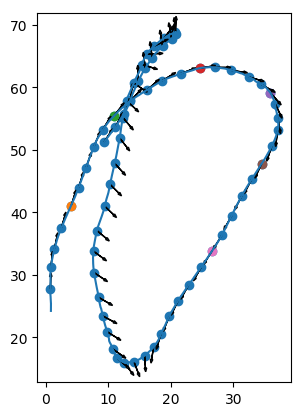

In [590]:
_ix1 = range(70+0, stop=70+700-1)
plot(recon[_ix1,1,1], recon[_ix1,1,3])
scatter(recon[_ix1[10:10:end],1,1], recon[_ix1[10:10:end],1,3])
[scatter(recon[tt,1,1], recon[tt,1,3]) for tt in _ix1[50:50:300]];

[arrow(recon[tt,1,1], recon[tt,1,3], Xs[t2-0,24+7]*2, Xs[t2-0,36+7]*2, head_width=0.4) for (tt, t2) in 
        zip(_ix1[10:10:end], _ix1[10:10:end] .- 70)];
gca().set_aspect("equal")

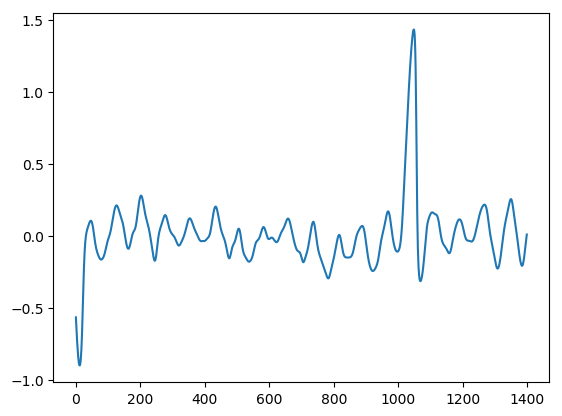

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0xb6065dcf8>

In [521]:
plot(atan.(Xs[1:1400,55], Xs[1:1400,55+12]))

* Derive phase

* standardise, mean/std etc.?

## Phase

* Smooth first _before_ calculating footsteps.
* (At which point do we count phase = $\pi$, $2\pi$? (Heel? Toe?))
* Disambiguate confused areas of footsteps.
    * Think about minimum time on floor.
    * How does this change between styles / activities?
    * What to do when long period off floor?
    * Perform clean-up to obtain 'foot contact', 'foot lift' for each foot.
    * Hidden Semi-Markov Model probably makes sense if set up correctly.
    * Then perform some interpolation insofar as it makes sense.
* Deal with standing / long time on the floor: doesn't make sense to interpolate directly.
    * probably need to handle time of contact, time leave the floor together.
* 


In [ ]:
function process_file(filename)
    
    anim, names, frametime = BVHpy.load(filename)
    
    # Subsample to 60 fps
    anim = get(anim,  range(0, length(anim)-1, step=2))
    
    # Do FK
    global_xforms = Animpy.transforms_global(anim)  # intermediate
    global_positions = global_xforms[:,:,1:3,4] ./ global_xforms[:,:,4:end,4]
    global_rotations = Quatpy.Quaternions.from_transforms(global_xforms)
    

    # Remove Uneeded Joints
    used_joints = [0, 2,  3,  4,  5, 7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 22, 25, 26, 27, 29] .+ 1
         
    positions = global_positions[:, used_joints,:]
    global_rotations = QuatpyGetItem(global_rotations,:,used_joints,:) 
    N = size(positions, 1)
    # ________________________________________________________

    # Put on Floor
    positions[:,:,2] .-= minimum(positions[:,:,2])
    
    # Get Foot Contacts
    # ------------------------------------------
    # >>>> SMOOTH FIRST? <<<<<<<<<<<<<<<
    # ------------------------------------------
    velfactor, heightfactor = [0.05,0.05], [3.0, 2.0]
    fid_l, fid_r = [3,4] .+1, [7,8] .+1
    
    feet_l_vmag_sq = sum(x->x^2, diff(positions[:, fid_l, 1:3], dims=1), dims=3) |> squeeze
    feet_l_h = positions[1:end-1, fid_l, 2]
    feet_l = (feet_l_vmag_sq .< velfactor') .& (feet_l_h .< heightfactor')
    
    feet_r_vmag_sq = sum(x->x^2, diff(positions[:, fid_r, 1:3], dims=1), dims=3) |> squeeze
    feet_r_h = positions[1:end-1, fid_r, 2]
    feet_r = (feet_r_vmag_sq .< velfactor') .& (feet_r_h .< heightfactor')
    
    # Get Root Velocity
    velocity = diff(positions[:,1:1,:], dims=1)
    
    # Remove translation
    positions[:,:,1] .-= positions[:,1:1,1]
    positions[:,:,3] .-= positions[:,1:1,3]
    
    # Get Forward Direction
    sdr_l, sdr_r, hip_l, hip_r = 14, 18, 2, 6  #13, 17, 1, 5
    across1 = positions[:,hip_l,:] - positions[:,hip_r,:]
    across0 = positions[:,sdr_l,:] - positions[:,sdr_r,:]
    across = across0 + across1
    across = across ./ sqrt.(sum(x->x^2, across, dims=2))
    
    direction_filterwidth = 20
#     forward = [cross(view(across, i,:), [0., 1, 0])' for i in 1:N] |>  x->reduce(vcat, x)  # crossprod
    forward = hcat(-across[:,3], zeros(size(across, 1), 1), across[:,1])  # crossprod (easy as spec. case)
    forward = filterspy.gaussian_filter1d(forward, direction_filterwidth, axis=0, mode="nearest")
    forward = forward ./ sqrt.(sum(x->x^2, forward, dims=2))
    
    # Get Root Rotation
    target = repeat([0,0,1]', N, 1)
    root_rotation = Quatpy.Quaternions.between(forward, target)
    root_rotation.qs = unsqueeze(root_rotation.qs, 2);
    root_rot_omitlast = QuatpyGetItem(root_rotation, 1:(N-1)) 
    rvelocity = (QuatpyGetItem(root_rotation, 2:N) * -root_rot_omitlast).to_pivots()
    
    # Local Space  # NEW: define position of joints relative to root
    local_positions = positions  # copy(positions)
    local_positions[:,:,1] .-= local_positions[:,1:1,1]  # x rel to root x
    local_positions[:,:,3] .-= local_positions[:,1:1,3]  # z rel to root z
    
    local_positions = root_rot_omitlast * local_positions[1:end-1,:,:]  |> toArray # remove Y rotation from pos
    local_velocities = diff(local_positions, dims=1)
    local_rotations = abs((root_rot_omitlast * QuatpyGetItem(global_rotations, 1:(N-1)))).log()
    
    root_rvelocity = Pivotspy.Pivots.from_quaternions(QuatpyGetItem(root_rotation, 2:N) * -root_rot_omitlast).ps
    global_velocities = root_rot_omitlast * velocity    |> toArray                # remove Y rotation from vel
    
    
    @assert (size(global_velocities, 2) == 1) "output assumes global_velocities dim2 = 1."
    omit_end = 1:(N-2)
    out = hcat(root_rvelocity[omit_end,:]
                ,global_velocities[omit_end,1,1]
                ,global_velocities[omit_end,1,3]
                ,feet_l[omit_end,:], feet_r[omit_end,:]
                ,collapseDim3Npy(local_positions[omit_end,:,:])
                ,collapseDim3Npy(local_velocities)
                ,collapseDim3Npy(local_rotations[omit_end,:,:])
#                 ,forward[omit_end,:]
        )
    return out
end